<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/11_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B1%D0%BE%D0%BB%D0%B5%D0%B2%D0%B0%D0%BD%D0%B8%D0%B9_%D0%BF%D0%BE_%D1%81%D0%B8%D0%BC%D0%BF%D1%82%D0%BE%D0%BC%D0%B0%D0%BC_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Определение заболеваний по симптомам (RNN)**



# 1 Постановка задачи


*Подготовьте рекурентную нейронную сеть, предназначенную для классификации заболеваний по базе симптомов. Использйте различные подходы, связанные с обработкой текстов:*

*1) Embedding + LSTM сеть;*

*2) Embedding + Conv1D сеть;*

*3) Embedding + сложная сеть из Dense, LSTM и Conv1D.*

*Добейтесь максимальной точности распознавания.*

*Используйте xLen = 50.*

# 2 Подгрузка библиотек и подключени едиска

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files   # Для работы с файлами
import os                        # Для работы с файлами

# "Магическая" команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils                                  # Для работы с категориальными данными
from tensorflow.keras.models import Sequential                      # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation      # Cтандартные слои (полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D      # Свёрточные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional     # Рекуррентные слои
from tensorflow.keras.preprocessing.text import Tokenizer           # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences   # Метод для работы с последовательностями
from tensorflow.python.keras.optimizers import Adam, RMSprop         # Алгоритмы обучения/оптимизации

from keras.preprocessing.text import Tokenizer, text_to_word_sequence # Инструменты предобработки текста от кераса

from sklearn.preprocessing import LabelEncoder             # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split       # Для разделения выборки на тестовую и обучающую

from google.colab import drive
import time                                                # Библиотека time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3 Подгрузка данных

In [ ]:
def readText(fileName):          # Объявление функции для чтения файла. На вход подаётся путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Чтение текста
  text = text.replace("\n", " ") # Перевод переносов строк в пробелы

  return text                    # Возвращение текста файла

className = ["Панкреатит", "Колит", "Гастрит", "Энтерит", "Холицестит", "Эзофагит", "Гепатит", "Аппендицит", "Дуоденит", "Язва"] # Объявление интересующих нас классов
nClasses = len(className)      # Подсчёт количества классов

In [ ]:
trainText = [] # Формирование обучающих текстов
testText = []  # Формирование тестовых текстов

trainText.append(readText('/content/drive/My Drive/HW_18/Панкреатит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Колит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Гастрит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Энтерит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Холицестит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Эзофагит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Гепатит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Аппендицит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Дуоденит.txt'))
trainText.append(readText('/content/drive/My Drive/HW_18/Язва.txt'))

testText.append(readText('/content/drive/My Drive/HW_18/Панкреатит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Колит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Гастрит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Энтерит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Холицестит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Эзофагит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Гепатит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Аппендицит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Дуоденит_val.txt'))
testText.append(readText('/content/drive/My Drive/HW_18/Язва_val.txt'))

In [ ]:
print(len(trainText))    # Количество элементов в trainText
print(len(trainText[3])) # Количество символов в первом источнике в trainText

10
4519


# 4 Преобразование текстовых данных в числовые

In [ ]:
cur_time = time.time()  # Засекаем текущее время
maxWordsCount = 20000   # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений.
# num_words = maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов.
# filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - исключение ненужных символов. Можно добавить сюда цифры.
# lower=True          - приведение слов к нижнему регистру
# split = ' '         - разделение пробелами слов, "слипшихся" в результате удаления '\n'
# char_level = False  - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words = maxWordsCount, filters = '–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower = True, split = ' ', oov_token = 'unknown', char_level = False)

tokenizer.fit_on_texts(trainText)             # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())    # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep = '')

Время обработки: 0.02c


In [ ]:
print(items[:50])                      # Просмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))    # Длина словаря

[('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('или', 5), ('тошнота', 6), ('рвота', 7), ('боли', 8), ('живота', 9), ('при', 10), ('животе', 11), ('после', 12), ('отрыжка', 13), ('с', 14), ('области', 15), ('слабость', 16), ('аппетита', 17), ('во', 18), ('вздутие', 19), ('тела', 20), ('изжога', 21), ('температуры', 22), ('повышение', 23), ('может', 24), ('рту', 25), ('пищи', 26), ('снижение', 27), ('еды', 28), ('диарея', 29), ('на', 30), ('температура', 31), ('иногда', 32), ('части', 33), ('подреберье', 34), ('стул', 35), ('метеоризм', 36), ('потеря', 37), ('к', 38), ('до', 39), ('правом', 40), ('верхней', 41), ('урчание', 42), ('не', 43), ('общая', 44), ('чувство', 45), ('эпигастральной', 46), ('ощущение', 47), ('кожи', 48), ('нарушение', 49), ('отсутствие', 50)]
Размер словаря 1644


In [ ]:
#print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) # Тестирование словаря частотности

In [ ]:
# Преобразовываем текста в последовательность индексов в соответствии с частотным словарём:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)  # Перевод обучающих текстов в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)    # Перевод проверочных текстов в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               постоянные позывы на дефекацию, урчание, вздутие живота, профузный понос, иногда с кров
Он же в виде последовательности индексов:  [284, 58, 30, 181, 42, 19, 9, 1000, 51, 32, 14, 182, 3, 285, 231, 8, 2, 11, 1001, 3] 



In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0       # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0         # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses):  # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i])       # Подсчёт символов
  wordsTrainText += len(trainWordIndexes[i])  # Подсчёт слов

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0        # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0          # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses):  # Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i])       # Подсчёт символов
  wordsTestText += len(testWordIndexes[i])  # Подсчёт слов
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Панкреатит  9647 символов,  1234 слов
Колит       7906 символов,  1028 слов
Гастрит     5207 символов,  629 слов
Энтерит     4519 символов,  567 слов
Холицестит  4994 символов,  680 слов
Эзофагит    4084 символов,  558 слов
Гепатит     3958 символов,  498 слов
Аппендицит  3056 символов,  439 слов
Дуоденит    2862 символов,  349 слов
Язва        2452 символов,  337 слов
----
В сумме  48685  символов,  6319  слов 


Статистика по тестовым текстам:
Панкреатит  1663 символов,  246 слов
Колит       1221 символов,  164 слов
Гастрит     1510 символов,  210 слов
Энтерит     1867 символов,  261 слов
Холицестит  1163 символов,  161 слов
Эзофагит    1783 символов,  235 слов
Гепатит     1565 символов,  189 слов
Аппендицит  1019 символов,  140 слов
Дуоденит    1079 символов,  139 слов
Язва        1008 символов,  135 слов
----
В сумме  13878  символов,  1880  слов


# 5 Создание обучающей и тестовой выборок

## 5.1 Функции для формирования выборки по отрезкам текста с заданным шагом

Формирование обучающей выборки по листу индексов слов
(разделение на короткие векторы)

In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):   # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = []                    # Объявление переменной для векторов
  wordsLen = len(wordIndexes)     # Подсчёт количества слов
  index = 0                       # Задаем начальный индекс

  while (index + xLen <= wordsLen):                   # Проходка по всей длине вектора индексов
    xSample.append(wordIndexes[index:index + xLen])   # "Откусываем" векторы длины xLen
    index += step                                     # Смещаеммся вперёд на шаг step

  return xSample

Формирование обучающей и проверочной выборки из двух листов индексов от двух классов

In [ ]:
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов создаём обучающую/проверочную выборку из индексов:
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером [кол-во классов] * [кол-во окон в тексте] * [длина окна]. Пример: с 6 по 1341*1000.
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на [кол-во окон] * [длина окна]

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером [суммарное кол-во окон во всех текстах] * [длина окна]. Например: 15779 * 1000.
  ySamples = [] # Здесь будет список размером [суммарное кол-во окон во всех текстах] * [вектор длиной 6]

  for t in range(nClasses):  # В диапазоне кол-ва классов(6):
    xT = classesXSamples[t]      # берем очередной текст вида [кол-во окон в тексте] * [длину окна]. Например: 1341 * 1000.
    for i in range(len(xT)):     # и каждое его окно:
      xSamples.append(xT[i])                              # добавляем в общий список выборки;
      ySamples.append(utils.to_categorical(t, nClasses))  # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples)  # Перевод в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples)  # Перевод в массив numpy для подачи в нейронку


  return (xSamples, ySamples)    # Функция возвращает выборку и соответствующие векторы классов

## 5.2 Подготовка данных

In [ ]:
# Задание базовых параметров
xLen = 50  # Длина отрезка текста, по которой анализируем, в словах
step = 1   # Шаг разбиения исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекание текущего времени
# Формирование обучающей и тестовой выборок
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # Извлечение обучающей выборки
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # Извлечение тестовой выборки
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

# Получен обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(5829, 50)
(5829, 10)
(1390, 50)
(1390, 10)
Время обработки: 0.12c


In [ ]:
print(xTrain[0])

[  4  10 201 104 114 729  66  81 447 323 448 730  82 731 449 732   4  93
 324  34 251 165 251 733   2 450  94 734 735 166   2 451 736 737 738 739
 252   4 253 254  81 115  31 740   5 452 741 255 202 203]


In [ ]:
for i in range(100):
  print(int(i in xTrain[0]),end=' ')

0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 

# 6 Уточнённые сведения о результатах распозначания проверочной выборки

In [ ]:
###########################
# Представляем тестовую выборку в удобных для распознавания размерах
##########################
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
  xTest10Classes01 = []               # здесь будет список из всех классов,каждый размером "кол-во окон в тексте * 20000(при maxWordsCount=20000)"
  xTest10Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest10Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
    xTest10Classes01.append(tokenizer.sequences_to_matrix(sample)) # трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest10Classes01 = np.array(xTest10Classes01)                     # и добавляется к нашему списку,

  return xTest10Classes01, xTest10Classes # функция вернёт тестовые данные: TestBg 6 классов на n*20000 и xTestEm 6 по n*1000

###########################
# Расспознаём тестовую выборку и выводим результаты
##########################
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()

  val = []
  pred = []

  totalSumRec = []

  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))

    totalSumRec.append(sumRec[i])

    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)

    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)

  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest10Classes01, xTest10Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

# 7 Перебор параметров

*(функции и цикл в настоящей работе не использовались)*

## 7.1 Подготовка функций

In [ ]:
activation_list = ['linear','relu','tanh','softmax','sigmoid', 'elu']

In [ ]:
def create_model(dense1_filters, use_dropout1, dropout1_value, use_bn1, dense1_activation, dense2_filters, use_dropout2, dropout2_value, use_bn2, dense2_activation):
  model = Sequential()
  model.add(Dense(dense1_filters, activation=activation_list[dense1_activation]))
  if (use_dropout1):
    model.add(Dropout(dropout1_value))
  if (use_bn1):
    model.add(BatchNormalization())
  model.add(Dense(dense2_filters, activation=activation_list[dense2_activation]))
  if (use_dropout2):
    model.add(Dropout(dropout2_value))
  if (use_bn2):
    model.add(BatchNormalization())
  model.add(Dense(1, activation='linear'))
  return model

def train_model(num_epoch, len, dense1_filters, use_dropout1, dropout1_value, use_bn1, dense1_activation, dense2_filters, use_dropout2, dropout2_value, use_bn2, dense2_activation):
  total = 0
  model = create_model(dense1_filters, use_dropout1, dropout1_value, use_bn1, dense1_activation, dense2_filters, use_dropout2, dropout2_value, use_bn2, dense2_activation)
  for i in range(num_epoch):
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(xTrain[:len], yTrain[:len], batch_size = 128, epochs= 10, verbose=0, validation_data = (xVal, yVal))
    total += float(history.history['val_loss'][-1])
  print('*** Результат теста ***')
  print('Модель')
  print('Dense(', dense1_filters,', activation=\'', activation_list[dense1_activation],'\')', sep='')
  if (use_dropout1):
    print('Dropout(',dropout1_value,')',sep='')
  if (use_bn1):
    print('BatchNormalization()')
  print('Dense(', dense2_filters,', activation=\'', activation_list[dense2_activation],'\')',sep='')
  if (use_dropout2):
    print('Dropout(',dropout2_value,')',sep='')
  if (use_bn2):
    print('BatchNormalization()')
  print('Dense(1, activation=\'linear\'')
  print()
  print(' -------------- ТОЧНОСТЬ МОДЕЛИ: ', round(total/num_epoch, 4),'---------------------')

In [ ]:
dense1_filters = [16, 32, 64]
use_dropout1 = [True, False]
dropout1_value = [0.1, 0.2, 0.3, 0.4]
use_bn1 = [True, False]
dense1_activation = [0,1,2,3,4,5]
dense2_filters = [16, 32, 64]
use_dropout2 = [True, False]
dropout2_value = [0.1, 0.2, 0.3, 0.4]
use_bn2 = [True, False]
dense2_activation = [0,1,2,3,4,5]

In [ ]:
for param1 in dense1_filters:
  for param2 in use_dropout1:
    for param3 in dropout1_value:
      for param4 in use_bn1:
        for param5 in dense1_activation:
          for param6 in dense2_filters:
            for param7 in use_dropout2:
              for param8 in dropout2_value:
                for param9 in use_bn2:
                  print('###################')
                  for param10 in dense2_activation:
                    train_model(5, 15000, param1, param2, param3, param4, param5, param6, param7, param8, param9, param10)

# 8 Создание нейронной сети

## 8.1 Embedding + LSTM сеть

*(при step = 10)*

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_116 (Embedding)    (None, 50, 20)            400000    
_________________________________________________________________
spatial_dropout1d_116 (Spati (None, 50, 20)            0         
_________________________________________________________________
batch_normalization_128 (Bat (None, 50, 20)            80        
_________________________________________________________________
lstm_116 (LSTM)              (None, 64)                21760     
_________________________________________________________________
dense_128 (Dense)            (None, 10)                650       
Total params: 422,490
Trainable params: 422,450
Non-trainable params: 40
_________________________________________________________________
Epoch 1/70
74/74 [==============================] - 1s 16ms/step - loss: 2.2700 - accuracy: 0.1812 - val_loss: 

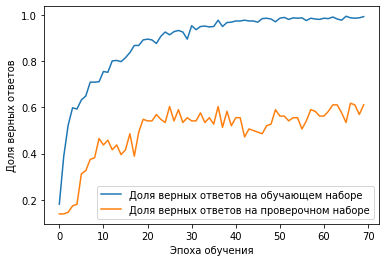

In [ ]:
brain_P_01 = Sequential()

brain_P_01.add(Embedding(maxWordsCount, 20, input_length=xLen))

brain_P_01.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
brain_P_01.add(BatchNormalization())  # добавляем слой нормализации данных
brain_P_01.add(LSTM(64)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU

brain_P_01.add(Dense(10, activation='sigmoid'))

brain_P_01.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

brain_P_01.summary()


history = brain_P_01.fit(xTrain,
                    yTrain,
                    epochs=70,
                    batch_size=8,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
_, xTest10Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(brain_P_01, xTest10Classes, "Embedding + LSTM")

НЕЙРОНКА:  Embedding + LSTM

Панкреатит  распознано  85 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Колит  распознано  66 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Гастрит  распознано  52 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Энтерит  распознано  77 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Холицестит  распознано  33 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  89 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Гепатит  распознано  78 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Аппендицит  распознано  20 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  33 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  61 %



## 8.2 Embedding + Conv1D сеть

*(при step = 1)*

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 20)            400000    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 50, 20)            0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 50, 20)            80        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 46, 20)            2020      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 42, 20)            2020      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 5, 20)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 20)            

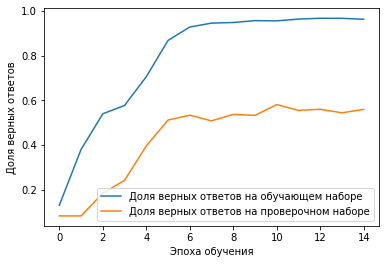

In [ ]:
brain_P_02 = Sequential()

brain_P_02.add(Embedding(maxWordsCount, 20, input_length=xLen))

brain_P_02.add(SpatialDropout1D(0.5))             # слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
brain_P_02.add(BatchNormalization())             # слой нормализации данных
brain_P_02.add(Conv1D(20, 5, activation="sigmoid"))  # одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
brain_P_02.add(Conv1D(20, 5, activation="sigmoid"))  # второй Conv1D для комплектности
brain_P_02.add(MaxPooling1D(8))                   # слой подвыборки/пулинга с функцией максимума
brain_P_02.add(Dropout(0.5))                      # слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
brain_P_02.add(BatchNormalization())              # слой нормализации данных
brain_P_02.add(Flatten())                         # слой выравнивания/сглаживания ("сплющиваем" данные в вектор)


brain_P_02.add(BatchNormalization())
brain_P_02.add(Dense(10, activation='sigmoid'))

brain_P_02.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

brain_P_02.summary()


history = brain_P_02.fit(xTrain,
                    yTrain,
                    epochs=15,
                    batch_size=32,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # Преобразование тестовой выборки
pred = recognizeMultiClass(brain_P_02, xTest10Classes, "Embedding + Conv1D")

НЕЙРОНКА:  Embedding + Conv1D

Панкреатит  распознано  40 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Колит  распознано  80 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Гастрит  распознано  36 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Энтерит  распознано  69 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Холицестит  распознано  10 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  49 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Гепатит  распознано  99 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Аппендицит  распознано  14 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  71 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  50 %



## 8.3 Embedding + LSTM + Conv1D + Dense сеть

*(при step = 1)*

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 50, 20)            400000    
_________________________________________________________________
spatial_dropout1d_43 (Spatia (None, 50, 20)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 50, 16)            2368      
_________________________________________________________________
dropout_117 (Dropout)        (None, 50, 16)            0         
_________________________________________________________________
dense_81 (Dense)             (None, 50, 10)            170       
_________________________________________________________________
dropout_118 (Dropout)        (None, 50, 10)            0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 50, 10)          

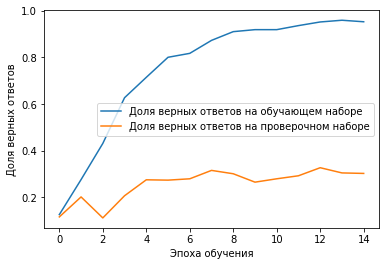

In [ ]:
brain_P_03 = Sequential()

brain_P_03.add(Embedding(maxWordsCount, 20, input_length=xLen))

brain_P_03.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
brain_P_03.add(LSTM(16, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU


brain_P_03.add(Dropout(0.3))
brain_P_03.add(Dense(10, activation="softmax"))

brain_P_03.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
brain_P_03.add(BatchNormalization()) # добавляем слой нормализации данных
brain_P_03.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
brain_P_03.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
brain_P_03.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
brain_P_03.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
brain_P_03.add(BatchNormalization()) # добавляем слой нормализации данных
brain_P_03.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
brain_P_03.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

brain_P_03.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

brain_P_03.summary()


history = brain_P_03.fit(xTrain,
                    yTrain,
                    epochs=15,
                    batch_size=64,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(brain_P_03, xTest10Classes, "Embedding + LSTM + Conv1D + Dense")

НЕЙРОНКА:  Embedding + LSTM + Conv1D + Dense

Панкреатит  распознано  0 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Колит  распознано  34 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Гастрит  распознано  40 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Энтерит  распознано  42 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Холицестит  распознано  4 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  67 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Гепатит  распознано  50 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Аппендицит  распознано  3 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  56 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Энтерит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  32 %



# 9 Результаты

Результаты обучения созданных нейронных сетей представлены в таблице 1.

In [ ]:
results = {'Name':['Embedding + LSTM', 'Embedding + Conv1D', 'Embedding + LSTM + Conv1D + Dense'],
        'Accuracy (After 20 Epoch)': [0.9932, 0.9623, 0.9520],
        'Validation Accuracy (After 20 Epoch)': [0.6111, 0.5590, 0.3022],
        'Total Time after for 1 Epoch (sec))': [1, 2, 2]}
results_base = pd.DataFrame(results)

In [ ]:
print('Таблица 1. Результаты работы обученных нейронных сетей')
results_base.head(4)

Таблица 1. Результаты работы обученных нейронных сетей


,Name,Accuracy (After 20 Epoch),Validation Accuracy (After 20 Epoch),Total Time after for 1 Epoch (sec))
0,Embedding + LSTM,0.9932,0.6111,1
1,Embedding + Conv1D,0.9623,0.5590,2
2,Embedding + LSTM + Conv1D + Dense,0.9520,0.3022,2


# 10 Выводы

Разработаны и обучены три нейронные сети, включающие в свой состав:

1) Embedding и LSTM слои;

2) Embedding и Conv1D слои;

3) Embedding, Dense, LSTM и Conv1D слои.

Обучение проводилось на сформированной вручную выборке.

В процессе обучения в параметры нейросетей вручную вносились измененеия. Наибольшее количество правильных ответов на проверочной выборке продемонстрировала сеть "Embedding + Dense". Наименьшее количество (за счёт быстрого пеереобучения) продемнстрировала сеть, включающая в свой состав LSTM, Conv1D и Dense слои.

Представляется возможным дальнейшее увеличение количества правильных ответов на проверочных выборках за счёт продолжения экспериментов по внесению изменений в параметры нейронных сетей, а также улучшения качества обучающей и проверочной выборок.